In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Self driving car model analysis

The purpose of this analysis is try to explain the train and test proceses. Analysing data and augmentation this to improve accurary and later simulation over udacity simulator.

Without further ado, let's start with the step-by-step process:

**Step 1**: Let's import required classes & functions:

In [2]:
from lib.config import Config
from lib.dataset_loader import DatasetLoader
from lib.model_factory import ModelFactory
from lib.data_generator import SteeringWheelAngleDataGenerator
from lib.image_preprocessor import ImagePreprocessor
from lib.sample_augmenter import SampleAugmenter
from lib.callback.callback_factory import CheckpointFactory, PlotLossesFactory
from lib.image_utils import load_image, vertical_crop_image, resize_image, rgb_to_yuv
from lib.plot_utils import show_image, show_distribution, show_sample
from lib.image_augmentation_utils import choose_image, random_image_flip, \
                                         random_image_translate, random_image_shadow, \
                                         random_image_brightness
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


**Step 2**: First of all check that has a GPU available. This is required to decrease learning training times: 

In [3]:
print("Available GPU's: ", K.tensorflow_backend._get_available_gpus())

Available GPU's:  ['/job:localhost/replica:0/task:0/device:GPU:0']


**Step 3**: Load config file.

In [4]:
cfg = Config('./config.yml')

### Load Train data

The dataset was previously generater using de **Training Mode** of UDacity simulator. This mode generate:

1. **IMG** directory that contain images taked with all cameras(left, center, right)

2. **driving_log.csv** file that contain examples with next columns:

In [5]:
cfg['dataset']['columns']

['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

When:
* **Center**, **Left** and **Right**: Are images paths. That images was taked from three cameras mounted in front of a car in the simulator.
* **Steering**: The car steering whell angle.
* **Throttle**: Car aceletation.
* **Reverse**
* **Speed**: Car speed.

**Step 1**: Load dataset

In [6]:
loader = DatasetLoader(cfg)

dataset = loader.load(
    features=cfg['dataset']['features'],
    labels=cfg['dataset']['labels']
)

dataset(8036) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_2/driving_log.csv 
dataset(6017) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_3/driving_log.csv 
dataset(3666) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_4/driving_log.csv 
dataset(7102) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_5/driving_log.csv 
dataset(3678) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_6/driving_log.csv 
dataset(7673) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_7/driving_log.csv 





Images


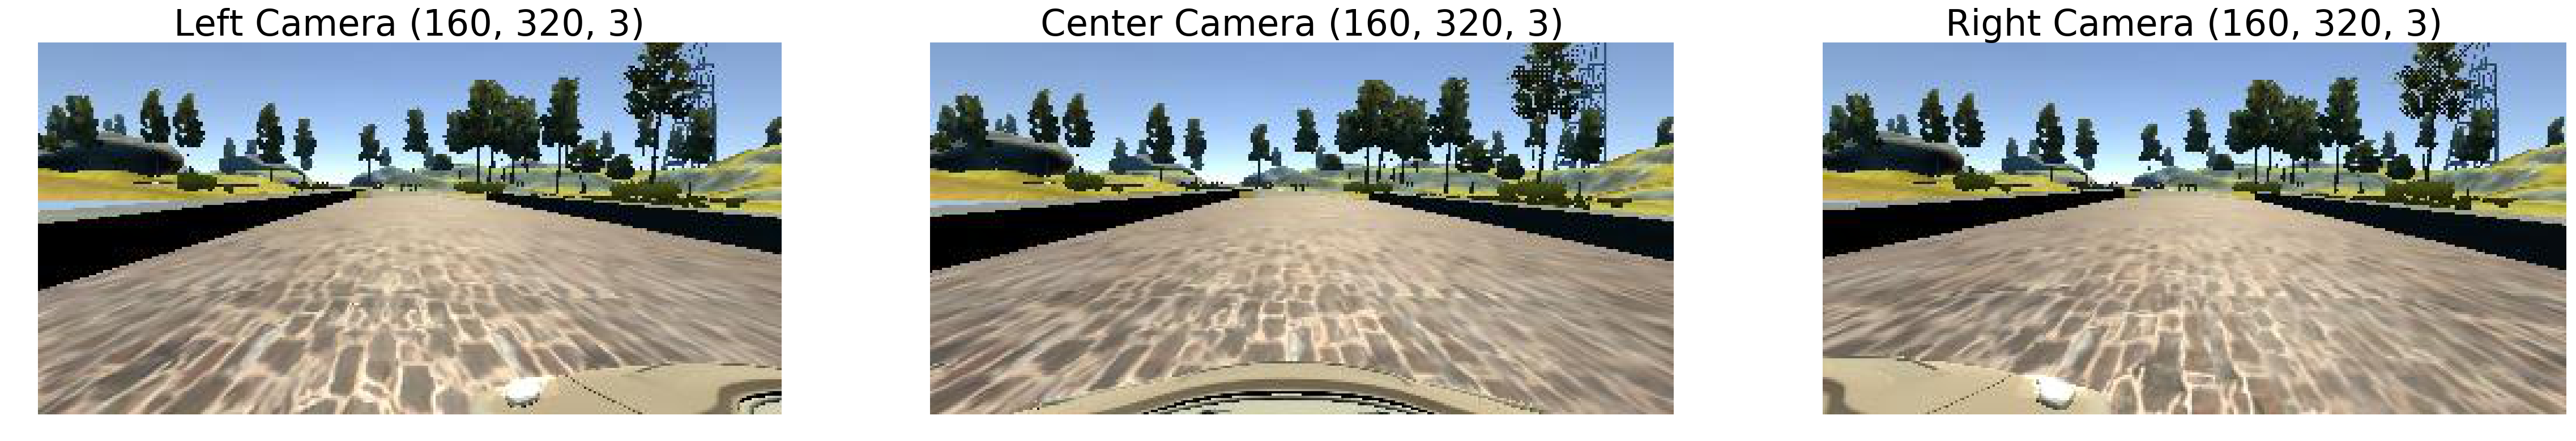

Steering Angle: 0.0




In [7]:
sample = dataset[0]
sample.show()

**Step 2**: Show streering angle distribution

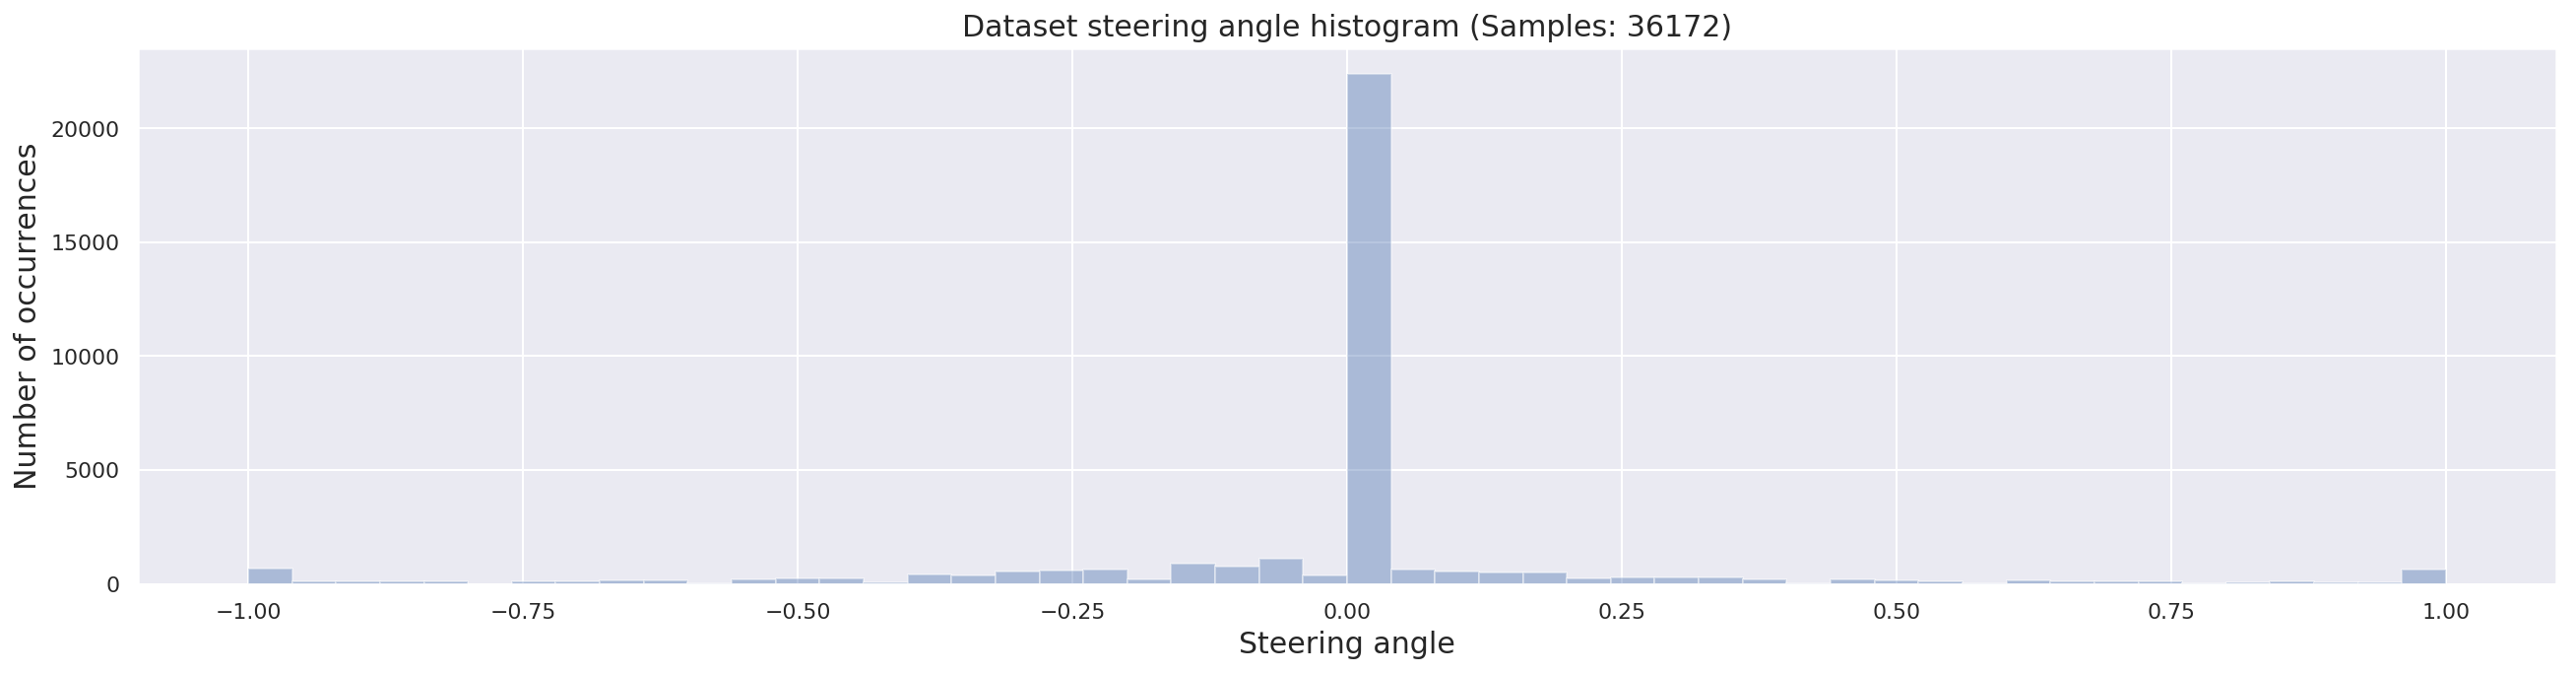

In [12]:
show_distribution(dataset, title='Dataset steering angle histogram')

**Step 2**: Split dataset in train and validation.

In [13]:
train_dataset, validation_dataset = dataset.split(percent=cfg['train']['validation_set_percent'], shuffle=True)

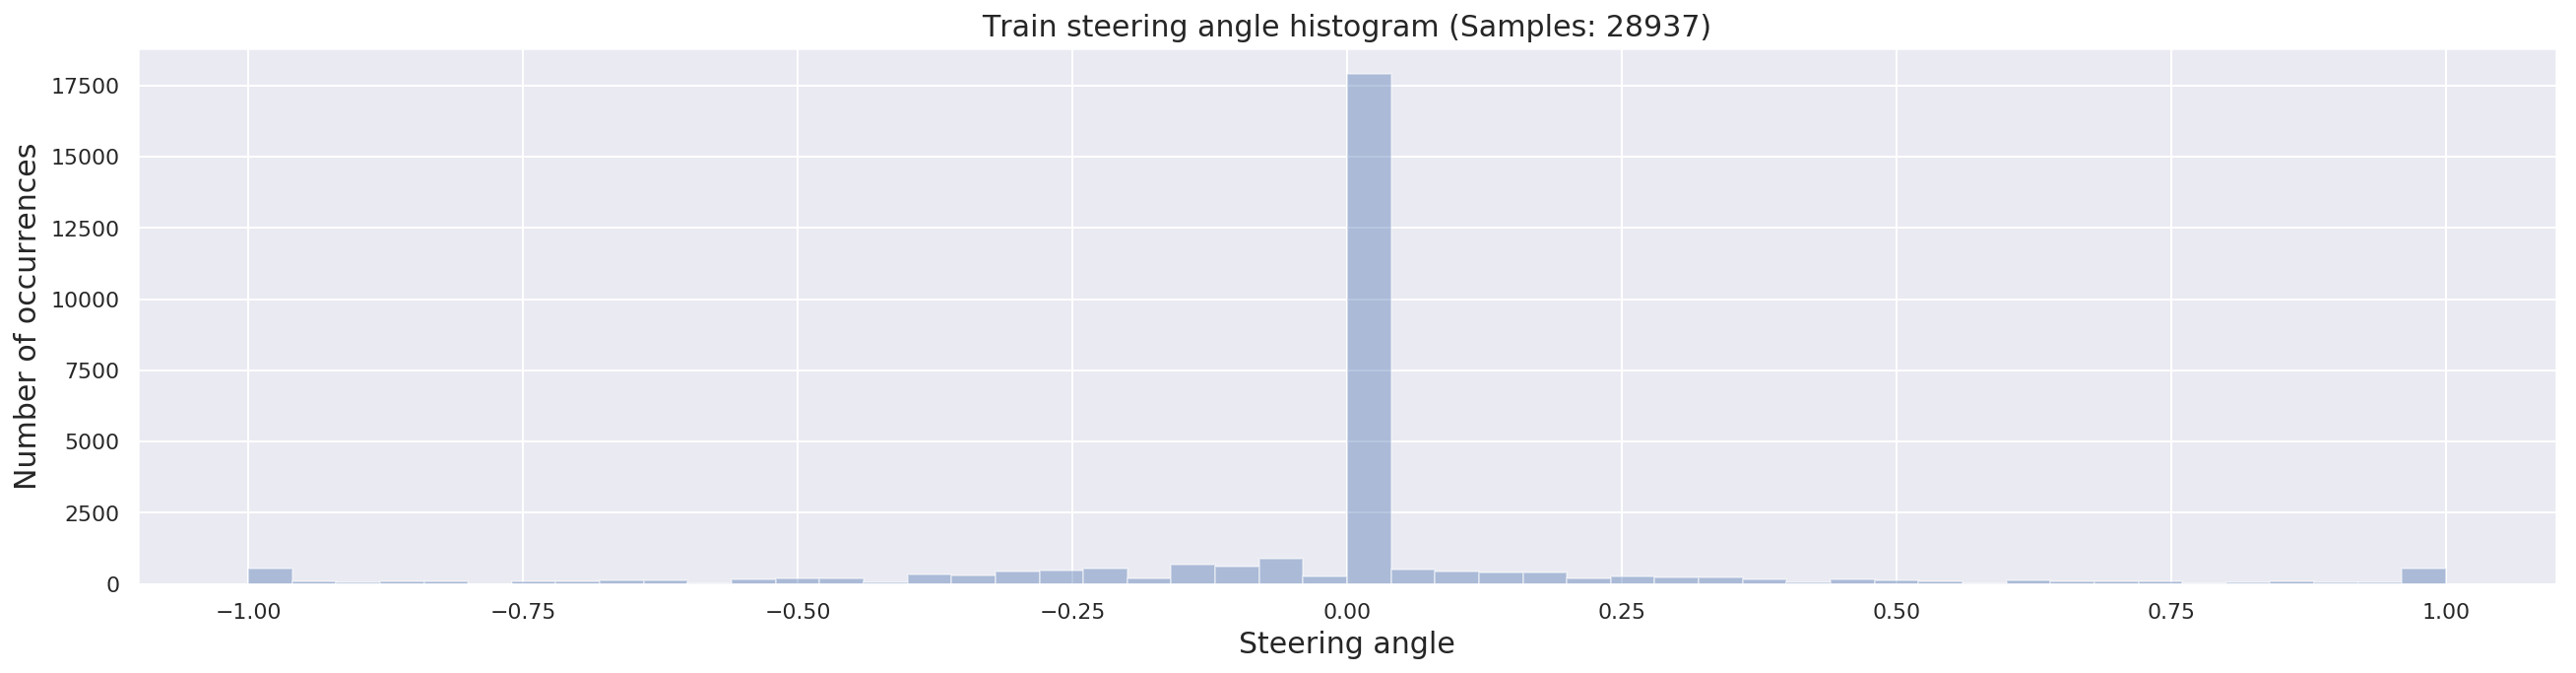

In [14]:
show_distribution(train_dataset, title='Train steering angle histogram')

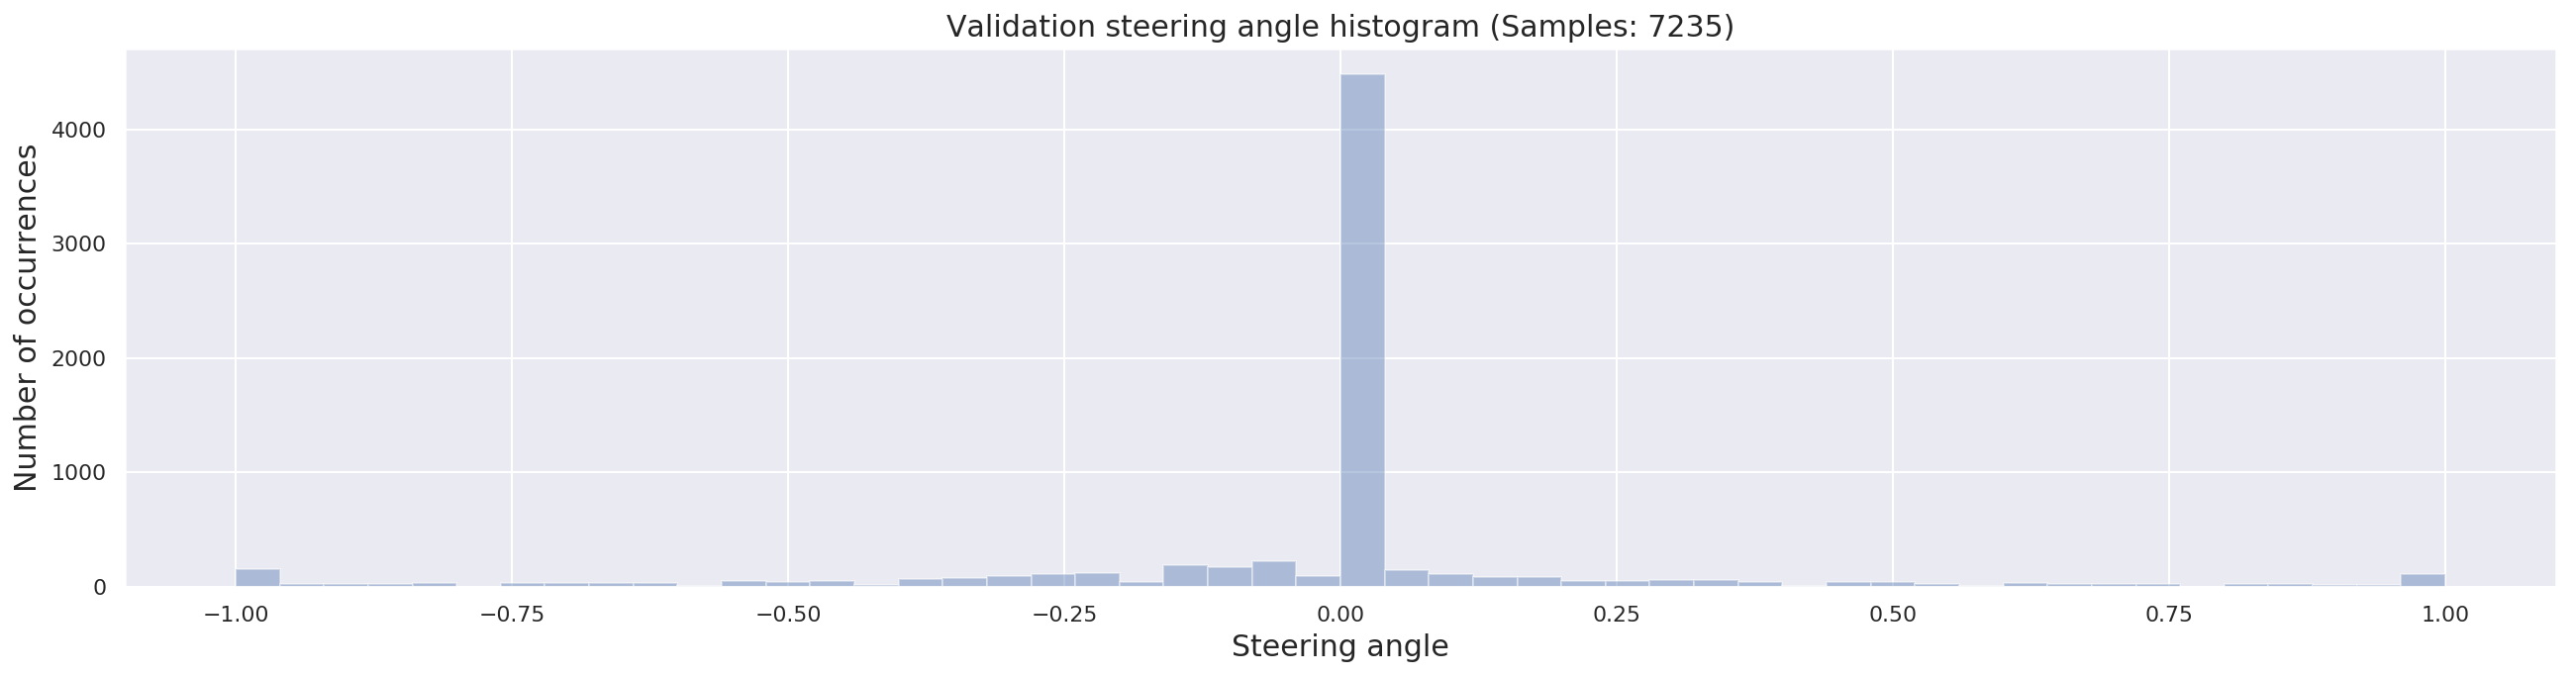

In [15]:
show_distribution(validation_dataset, title='Validation steering angle histogram')

### Data generation process

After all is necessary explain three importante points:

* A generator allow us to generator a dataset for augment and/or preprocess and in this way increase samples amount. 
* Since in most cases dataset does not fit in memory a generator allow as to save memory space, loading only a subset of this on each train batch.
* A generator also allow us to process data using multiples cpu cores.

On the other hand, data augmentation and preprocessing is required to improve model accuracy. Particularly for this problem is required two flows to generate samples:

* **Train samples generation**:
    * Augment & preprocess a randomly image from the center, left or right cameras.
    * Preproress agmented image.
    * Steering angles is adjustes in each case.

* **Validation samples generation**: Only preprocess center camera image.

But what does augmentation and preprocess means?
        
* **Augmentation steps**: 
    1. Randomly choose an image from the center, left or right, and adjust the steering angle.
    2. Randomly flip the image left <-> right, and adjust the steering angle.
    3. Randomly shift the image vertically and horizontally (translation).
    4. Generates and adds random shadow.
    5. Randomly adjust brightness of the image.

* **Preprocessing steps**:
    1. Crop the image (removing the sky at the top and the car front at the bottom).
    2. Resize the image to the input shape used by the network model.
    3. Convert the image from RGB to YUV (This is what the NVIDIA model does).

#### Augmentation steps

Let's get a samples centrar image to show each augmentation effect:




Images


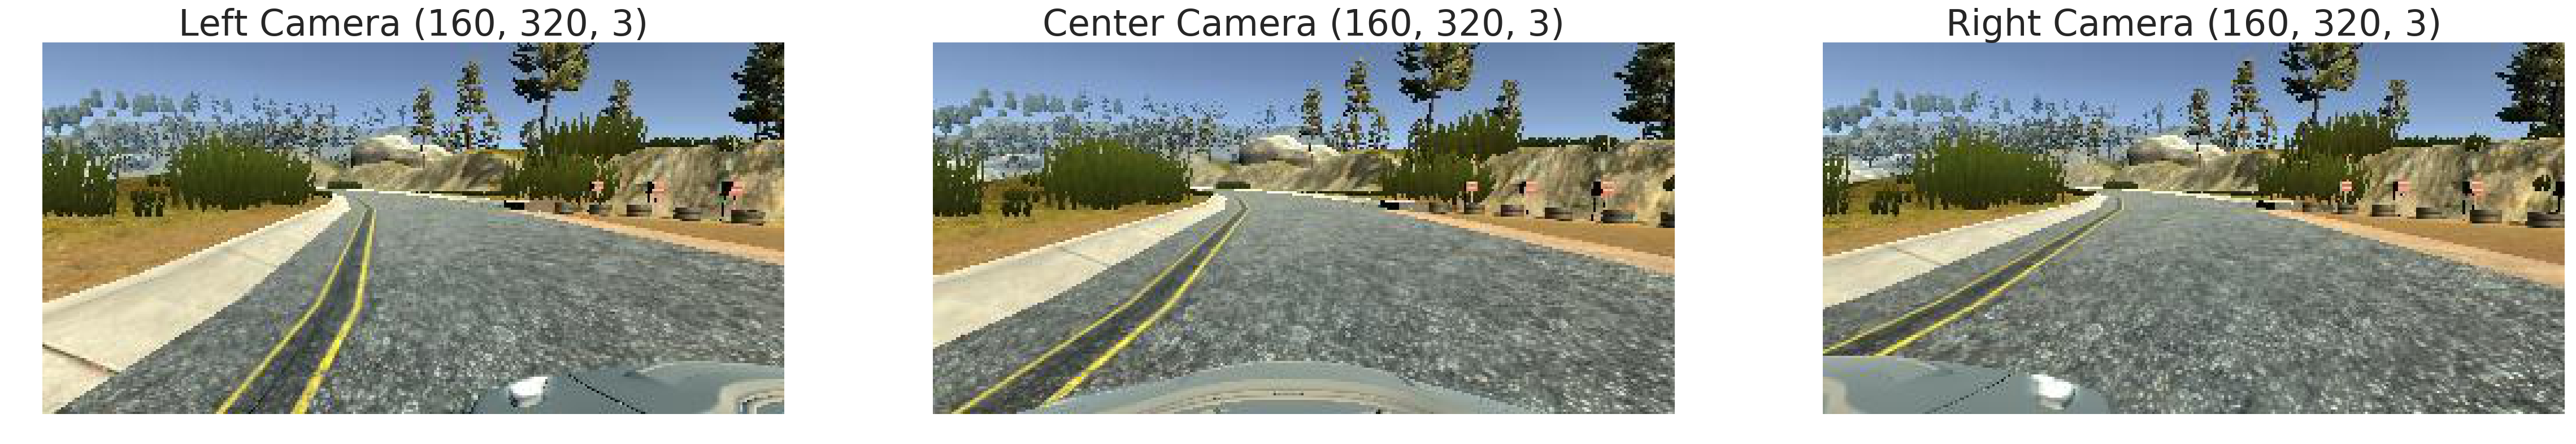

Steering Angle: 0.1150144




In [34]:
sample = dataset.shuffle()[0]
sample.show()

**Randomly choose an image**: From the center, left or right, and adjust
    the steering angle.

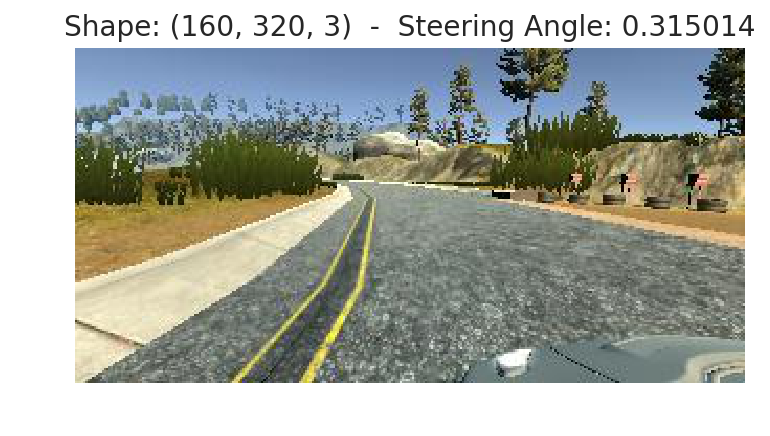

In [35]:
img, angle = choose_image(
    sample.center_image_path(), 
    sample.left_image_path(), 
    sample.right_image_path(), 
    sample.steering_angle(),
    adjustment_angle=0.2
)
show_sample(img, angle)

**Randomly flip image**: Randomly flip the image left <-> right, and adjust the steering angle.

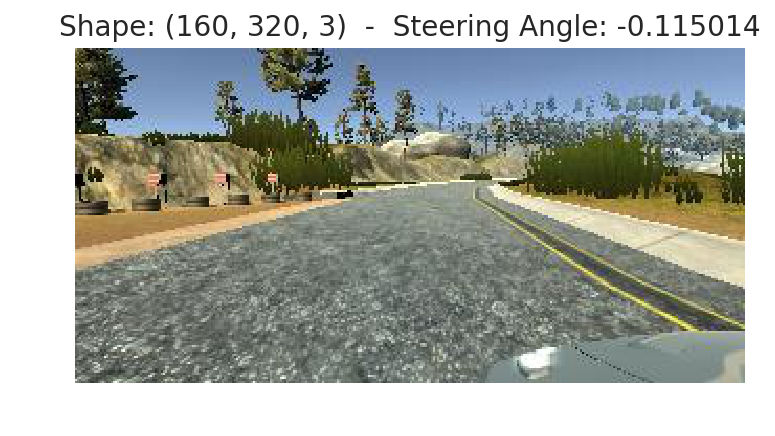

In [36]:
img, angle = random_image_flip(sample.right_image(), sample.steering_angle())
show_sample(img, angle)

**Randomly translate**: Randomly shift the image vertically and horizontally.

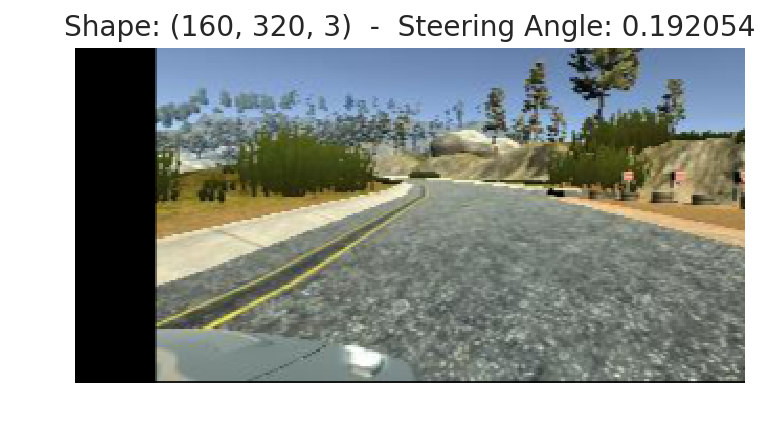

In [37]:
img, angle = random_image_translate(
    sample.right_image(), 
    sample.steering_angle(),
    range_x=100, 
    range_y=10,
    angle_delta=0.002
)
show_sample(img, angle)

**Random shadow**: Generates and adds random shadow.

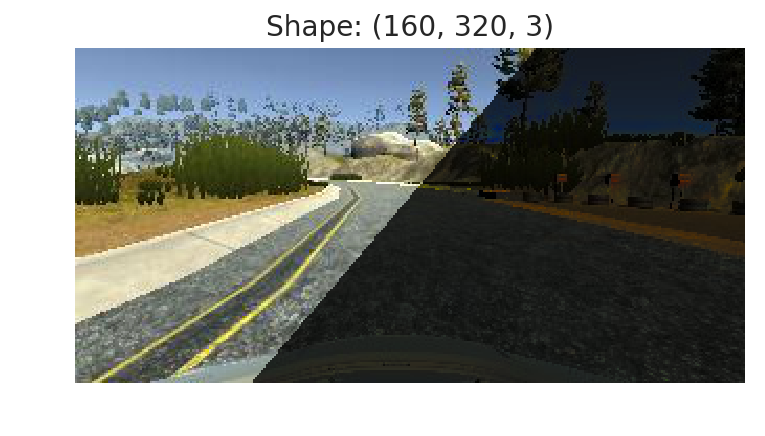

In [38]:
show_sample(random_image_shadow(sample.center_image(), width=320, height=160))

**Randomly brightness**: Randomly adjust brightness of the image.

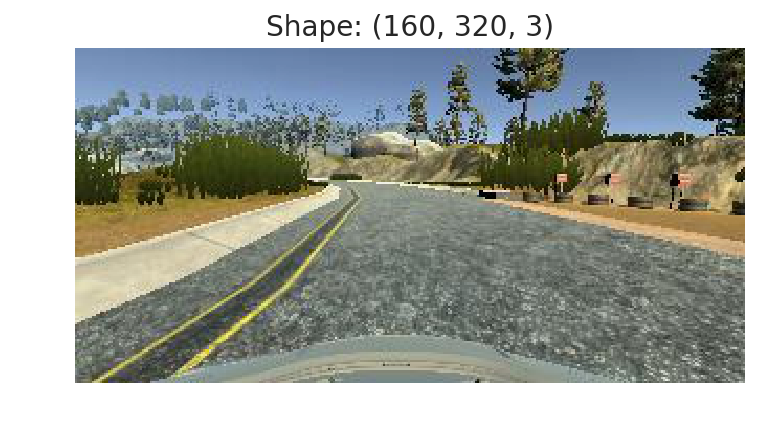

In [39]:
show_sample(random_image_brightness(sample.center_image()))

#### Preprocessing steps

Let's get a samples centrar image to show each preprocessing step:

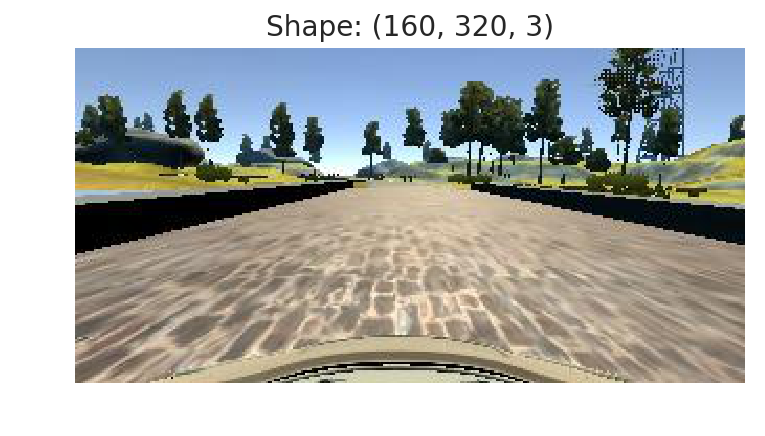

In [40]:
image = load_image(dataset[0].features[0])
show_sample(image)

**Step 1:** Randomly choose an image from the center, left or right, and adjust the steering angle.

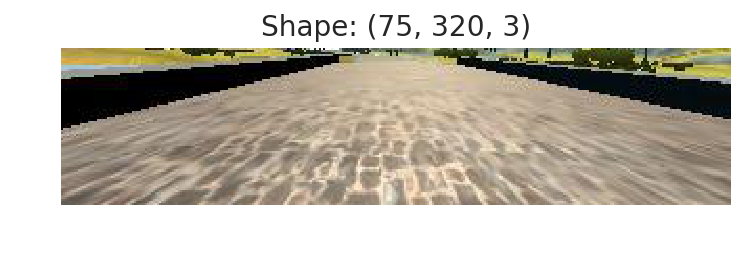

In [41]:
choped_image = vertical_crop_image(image, top_offset=60, bottom_offset=25)
show_sample(choped_image)

**Step 2**: Resize the image to the input shape used by the network model.

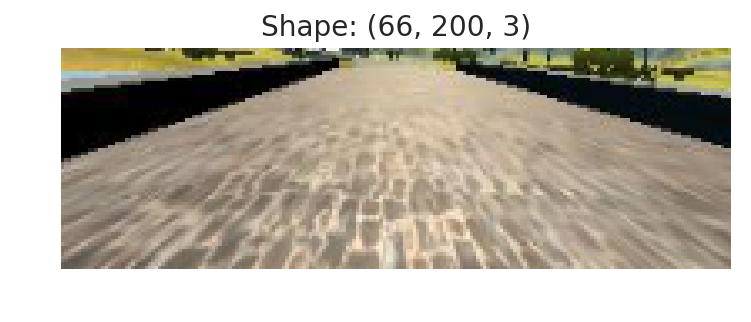

In [42]:
resized_image = resize_image(choped_image, 200, 66)
show_sample(resized_image)

**Step 3**: Convert the image from RGB to YUV (This is what the NVIDIA model does).

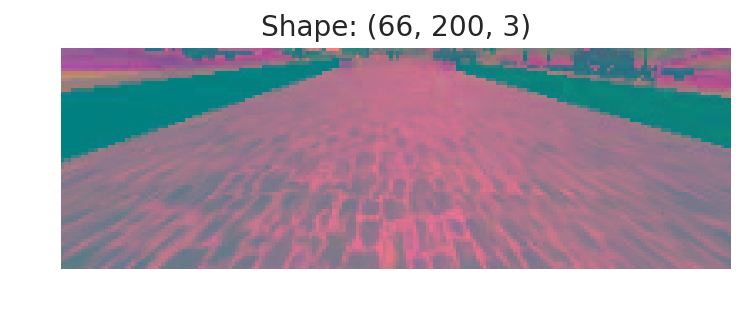

In [43]:
show_sample(rgb_to_yuv(resized_image))

#### Create train and validation data generators

In [44]:
input_shape=(
    cfg['network']['input_shape']['height'],
    cfg['network']['input_shape']['width'],
    cfg['network']['input_shape']['channels']
)
output_shape=[1]
batch_size = cfg['train']['batch_size']
augment_threshold = cfg['train']['augment']['threshold']
choose_adjustment_angle =  cfg['train']['augment']['choose_adjustment_angle']
translate_range_x = cfg['train']['augment']['translate_range_x']
translate_range_y = cfg['train']['augment']['translate_range_y']
translate_angle_delta = cfg['train']['augment']['translate_angle_delta']
top_offset=cfg['train']['preprocess']['crop']['top_offset']
bottom_offset=cfg['train']['preprocess']['crop']['bottom_offset']

In [45]:
print("Input shape: ", input_shape)
print("Output shape: ", output_shape)
print("Number of samples by batch: ", batch_size)
print("Image augment threshold: ", augment_threshold)
print("Adjusment angle delta when choose an image: ", choose_adjustment_angle)
print("Image translate x range: ", translate_range_x)
print("Image translate y range: ", translate_range_y)
print("Image translate angles delta: ", translate_angle_delta)
print("Image crop top offset: ", top_offset)
print("Image crop bottom offset: ", bottom_offset)

Input shape:  (66, 200, 3)
Output shape:  [1]
Number of samples by batch:  300
Image augment threshold:  0.6
Adjusment angle delta when choose an image:  0.25
Image translate x range:  100
Image translate y range:  10
Image translate angles delta:  0.0035
Image crop top offset:  80
Image crop bottom offset:  25


In [46]:
image_preprocessor=ImagePreprocessor(top_offset, bottom_offset, input_shape)

In [47]:
sample_augmenter = SampleAugmenter(augment_threshold, translate_range_x, translate_range_y)

In [48]:
train_generator = SteeringWheelAngleDataGenerator(
    dataset=train_dataset,
    input_shape=input_shape,
    output_shape=output_shape,
    batch_size=batch_size,
    sample_augmenter=sample_augmenter,
    image_preprocessor=image_preprocessor,
    shuffle_per_epoch=True
)

In [49]:
# show_distribution(train_generator.generate(batch_count=2), title='Train augmented steering angle histogram')

In [50]:
validation_generator = SteeringWheelAngleDataGenerator(
    dataset=validation_dataset,
    input_shape=input_shape,
    output_shape=output_shape,
    batch_size=batch_size,
    image_preprocessor=image_preprocessor
)

### Create NVidia model




MODEL LAYERS

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 98, 24)        96        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 47, 36)        144       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 22, 48)         192 

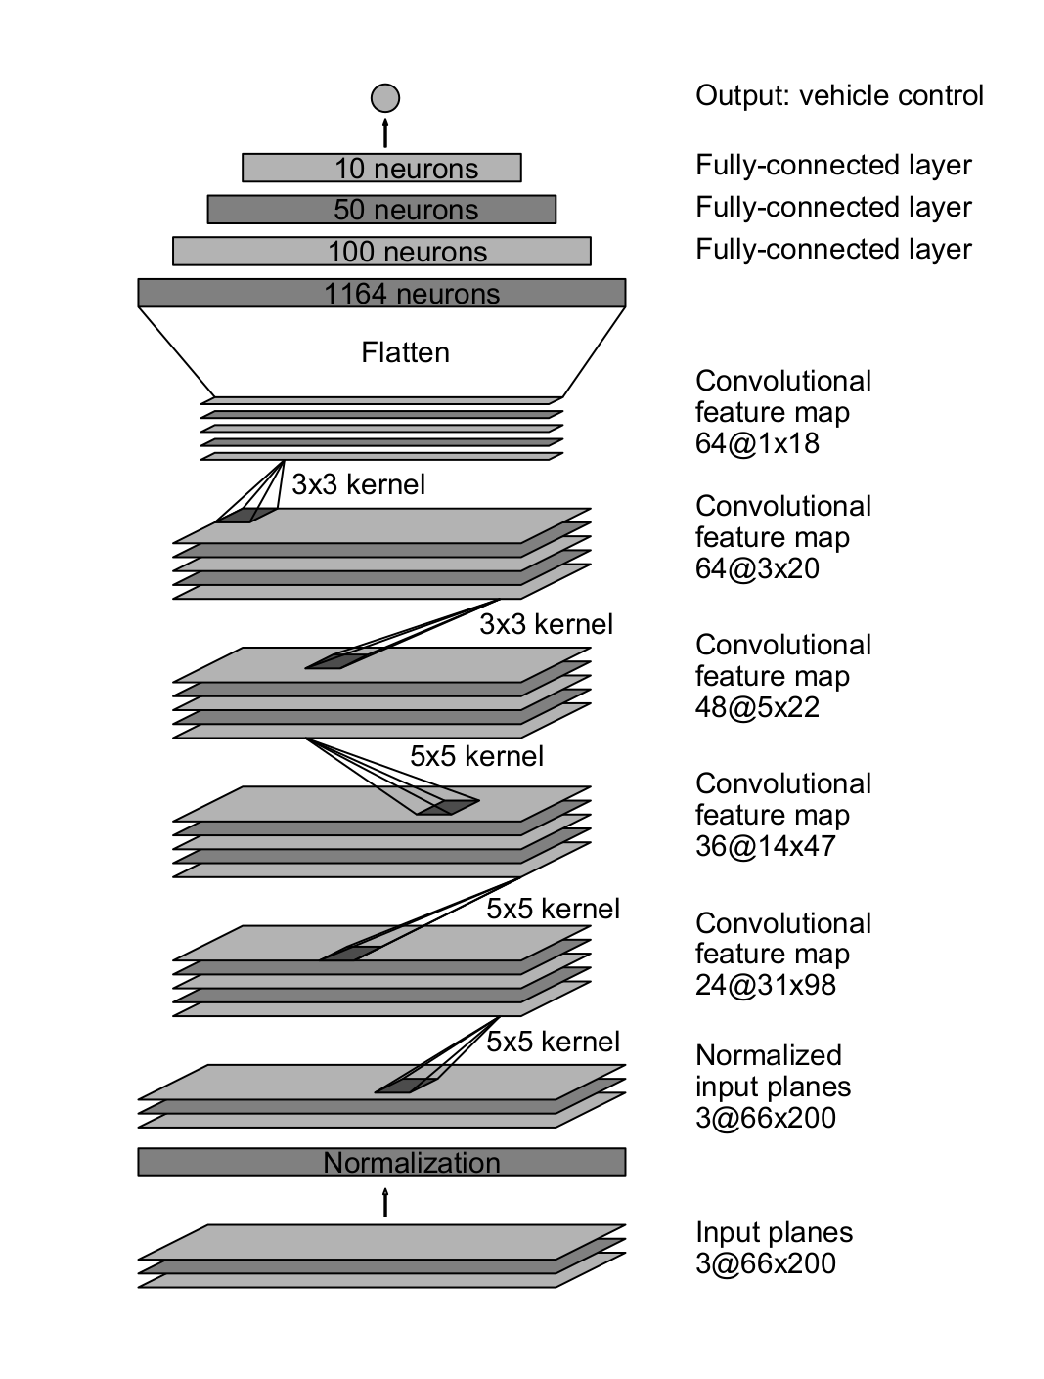

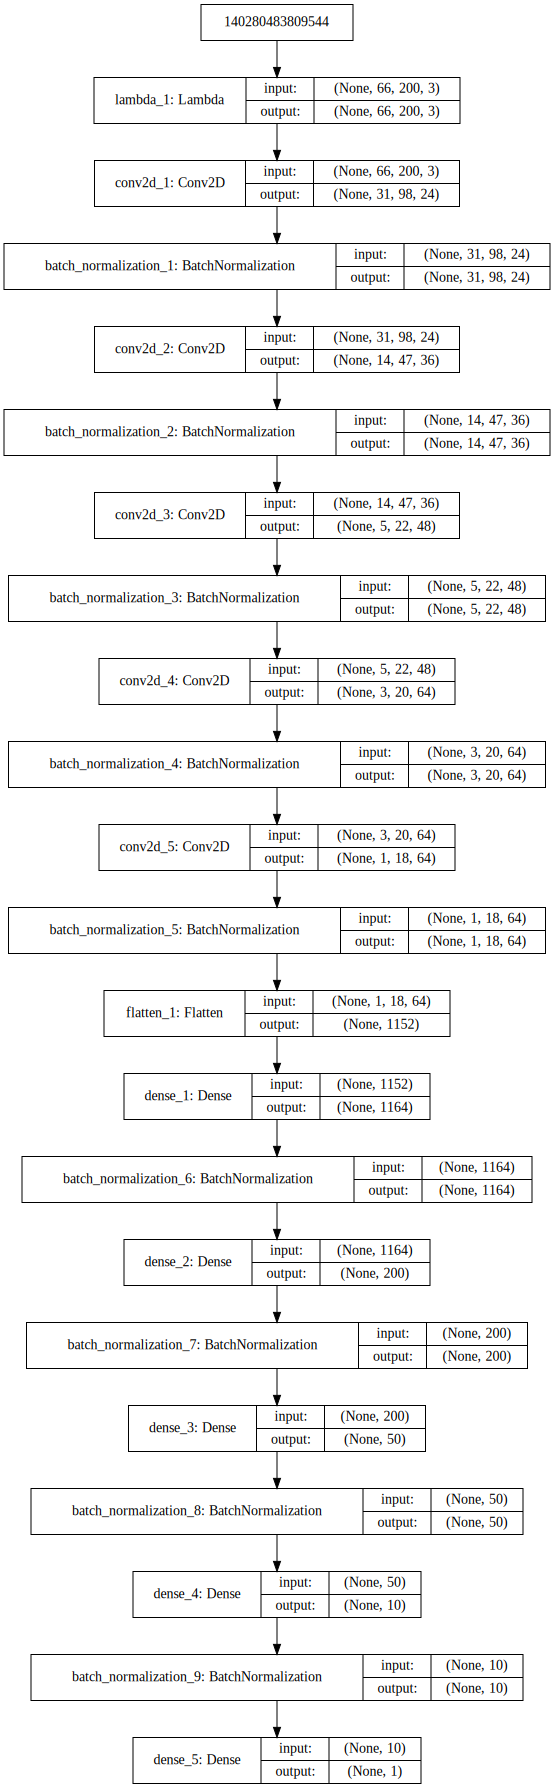

In [51]:
activation='relu'
loss='mean_squared_error'
optimizer=Adam(lr=0.001)

model = ModelFactory.create_nvidia_model(input_shape, activation, loss, optimizer)

model.show()

### Train Model

In [52]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

checkpoint_factory = CheckpointFactory(path=cfg['train']['checkpoint_path'])

checkpoint = checkpoint_factory.create(model_name=model.name, metric='val_loss')

plot_losses = PlotLossesFactory.create(
    plot_interval=1, 
    evaluate_interval=10,
    x_val=None,
    y_val_categorical=None
)
callbacks=[checkpoint, early_stopping]

In [54]:
steps_per_epoch=2000
epochs=5

**Steps per epoch**: Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. It should typically be equal to the number of unique samples of your dataset divided by the batch size.

i.e.: When steps_per_epoch == 5 then model fit 5 baches por epoch and use 5 * batch_size samples.

**samples_per_epoch = steps_per_epoch * batch_size**


In [55]:
model.train(
    generator=train_generator,
    validation_generator=validation_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=callbacks
) 

Epoch 1/5
2000/2000 [==============================] - 551s 275ms/step - loss: 0.0756 - acc: 0.2478 - val_loss: 0.0507 - val_acc: 0.6181

Epoch 00001: val_loss improved from inf to 0.05070, saving model to checkpoints/nvidia_mode_weights--epoch_001--val_loss_0.0507--val_acc_0.6181--val_loss_0.0756--val_acc_0.2478.h5
Epoch 2/5
2000/2000 [==============================] - 550s 275ms/step - loss: 0.0571 - acc: 0.2520 - val_loss: 0.0457 - val_acc: 0.6206

Epoch 00002: val_loss improved from 0.05070 to 0.04572, saving model to checkpoints/nvidia_mode_weights--epoch_002--val_loss_0.0457--val_acc_0.6206--val_loss_0.0571--val_acc_0.2520.h5
Epoch 3/5
2000/2000 [==============================] - 561s 280ms/step - loss: 0.0518 - acc: 0.2536 - val_loss: 0.0470 - val_acc: 0.6229

Epoch 00003: val_loss did not improve from 0.04572
Epoch 4/5
2000/2000 [==============================] - 568s 284ms/step - loss: 0.0462 - acc: 0.2559 - val_loss: 0.0509 - val_acc: 0.6165

Epoch 00004: val_loss did not imp

### References

##### 1. Dropout

* [Dropout](https://youtu.be/Ty6K6YiGdBs)
* [Dropout RENDER](https://youtu.be/6DcImJS8uV8)
* [Dropout Pt. 2 RENDER](https://youtu.be/8nG8zzJMbZw)

##### 2. Activation Functions

* [Introduction to Exponential Linear Unit](https://medium.com/@krishnakalyan3/introduction-to-exponential-linear-unit-d3e2904b366c)
* [Which Activation Function Should I Use?](https://youtu.be/-7scQpJT7uo)

#### 3. Data Generations

* [A detailed example of how to use data generators with Keras](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

#### 4. Datasets

* [Udacity P3 - DriveGG](https://github.com/bpinaya/Udacity-P3-DriveGG)

#### 5. Links

* [Teaching Cars To Drive Using Deep Learning — Steering Angle Prediction](https://towardsdatascience.com/teaching-cars-to-drive-using-deep-learning-steering-angle-prediction-5773154608f2)
* [Teaching Vehicles To Drive Like We Do Using Deep Learning](https://github.com/kenshiro-o/CarND-Behavioral-Cloning-P3)